Now that we know how to create pdf for the GEV distribution we can use it to compute return values 
based on a GEV distribution.

We  compute return levels from a pdf by using the cumulative distribution function (CDF), which tells us
the chance that a randomly drawn variable from our distribution will be less than some value X (for our 
variable). Rare extreme values thus have a high chance (as most random draws will be smaller – small storms).
Again, say that there is a 99% chance that we will see a storm of 80mm or higher… than there is a 1% change
we will see a storm of at least 80mm – and given what we said above it means the 100-year storm will bring 
80mm of rain. Formally the return level is the inverse of the CDF – for here all you need to know is that 
you can compute return-levels using the function qgev(x,location,scale,shape). In this case x is the chance
a random value from our distribution is lower – so for the 100-year storm this would be 0.99; and for the
1000-year storm 0.999.  

First repeat the steps from the previous tutorials and open the precipitation data... and fit a GEV distribution
to it.

In [1]:
# # <Yosmely Bermúdez> comments
# #install dependencies
# # We need this to install eigen which is needed for SDFC to install correctly
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !conda install eigen
# !pip install -v https://github.com/yrobink/SDFC/archive/master.zip#subdirectory=python
# !pip install https://github.com/njleach/mystatsfunctions/archive/master.zip
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas
# !pip install cartopy
# !pip install scipy
# !pip install texttable

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy import stats

import extremes_functions as ef
from mystatsfunctions import OLSE,LMoments
import SDFC as sd

In [3]:
import os, pooch

fname = 'precipitationGermany_1920-2022.csv'
if not os.path.exists(fname):
    url = "https://osf.io/xs7h6/download"
    fname = pooch.retrieve(url, known_hash=None)

data = pd.read_csv(fname, index_col=0).set_index('years')

data.columns=['precipitation']
precipitation = data.precipitation

In [4]:
fit, model = ef.fit_return_levels_sdfc(precipitation.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=10,full=True,model=True)

In [5]:
def estimate_return_level(quantile,model):
    loc, scale, shape = model.coef_
    level = loc - scale / shape * (1 - (-np.log(quantile))**(-shape))
    # level = stats.genextreme.ppf(quantile,-shape,loc=loc,scale=scale)
    return level

Now try to compute the 2-year storm level... the level of precipitation we expect with a 50% chance each year. For 
you will need to use the function qgev(x, location, scale, shape) which gives you variable value for any quantile
For example 90th quantile (0.9) would give the 10-year precipitation value (10% change of seeing it every year).

In [6]:
estimate_return_level(0.5,model)

29.07804011079916

In [7]:
stats.genextreme.ppf(0.5,-model.shape.mean(),loc=model.loc.mean(),scale=model.scale.mean())

29.078040110799137

It is probably easier to replace x with a variable called “rp” (= return period). You can use the formula 1-(1/return period)
to compute rp. So a 100-year storm would be 1-(1/100) = 0.99. Compute the 100- and 1000-year storm. 

In [8]:
estimate_return_level(1-1/80,model)

62.16649374058938

In [9]:
estimate_return_level(1-1/1000,model)

86.5193094598126

Now we will make a figure in which we plot return-levels against return-periods:
1. Create vector “periods” which is a sequence of 2 to a 1000-years (in steps of 2).
2. Create a vector “levels” which is the associated return-levels for those return periods.
3. Plot them against each other. Typically the return periods go on the x-axis at a log-scale.


[]

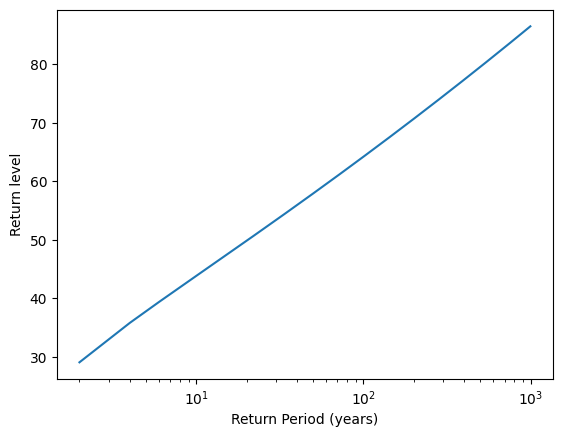

In [10]:
periods = np.arange(2,1000,2)
quantiles = 1-1/periods
levels = estimate_return_level(quantiles,model)
# plt.plot(x,estimate_return_level(x,model))
plt.plot(periods,levels)
plt.xlabel('Return Period (years)')
plt.ylabel('Return level')

plt.semilogx()

Finally it would be interesting to compare the return levels from a normal and GEV distribution. Compute the 
50-,100-,500- and 1000-year based on a normal distribution (use qnorm() ) and based on the GEV distribution
like above.

In [11]:
years = np.array([50,100,500,1000])
quantiles = 1-1/years

df = pd.DataFrame(index=years)
df['Normal Distribution'] = stats.norm.ppf(quantiles,loc=precipitation.mean(), scale=precipitation.std())
df['GEV'] = stats.genextreme.ppf(quantiles,-model.shape.mean(),loc=model.loc.mean(),scale=model.scale.mean())

In [12]:
df

,Normal Distribution,GEV
50,51.359942,57.922623
100,54.066103,64.209805
500,59.544102,79.554969
1000,61.649382,86.519309


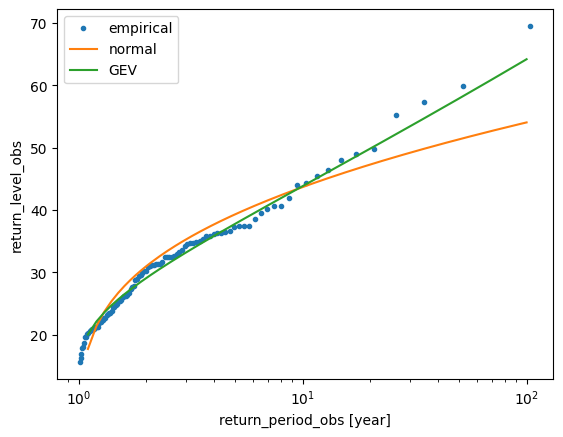

In [13]:
fit.return_level_obs.plot.line('.')
years = np.arange(1.1,100,0.1)
plt.plot(years,stats.norm.ppf(1-1/years,loc=precipitation.mean(), scale=precipitation.std()))
plt.plot(years,stats.genextreme.ppf(1-1/years,-model.shape.mean(),loc=model.loc.mean(),scale=model.scale.mean()))

plt.semilogx()

plt.legend(['empirical','normal','GEV'])

How do your answers compare?